<a href="https://colab.research.google.com/github/n1az/dog-vision-ai/blob/main/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-end MuMulti-class Dog Bread Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the bread of a dog given an image of dogs.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed it is.

## 2. Data

The data we are using is from Kaggle's dog breed identification competetion.

## 3. Evaluation

The evaluation is a file prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs.
* There are around 10000+ images in the training set. ( These images have labels).
* There are around 10000+ images in the test set. ( these images have no labels, because we'll want to predict them)


### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [1]:
# Import TensorFlow into Colab
import tensorflow as tf
print("TF version:", tf.__version__)

TF version: 2.5.0


In [2]:
# Import TensorFlow Hub
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)

# Check for GPU avaialability
print("GPU", "available (YESSS!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF Hub version: 0.12.0
GPU available (YESSS!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [3]:
# Checkout the lables of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/MLPROJECT/DOG_VISON/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     f5feb8aae47a107bc2e8ca4075286ae5  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


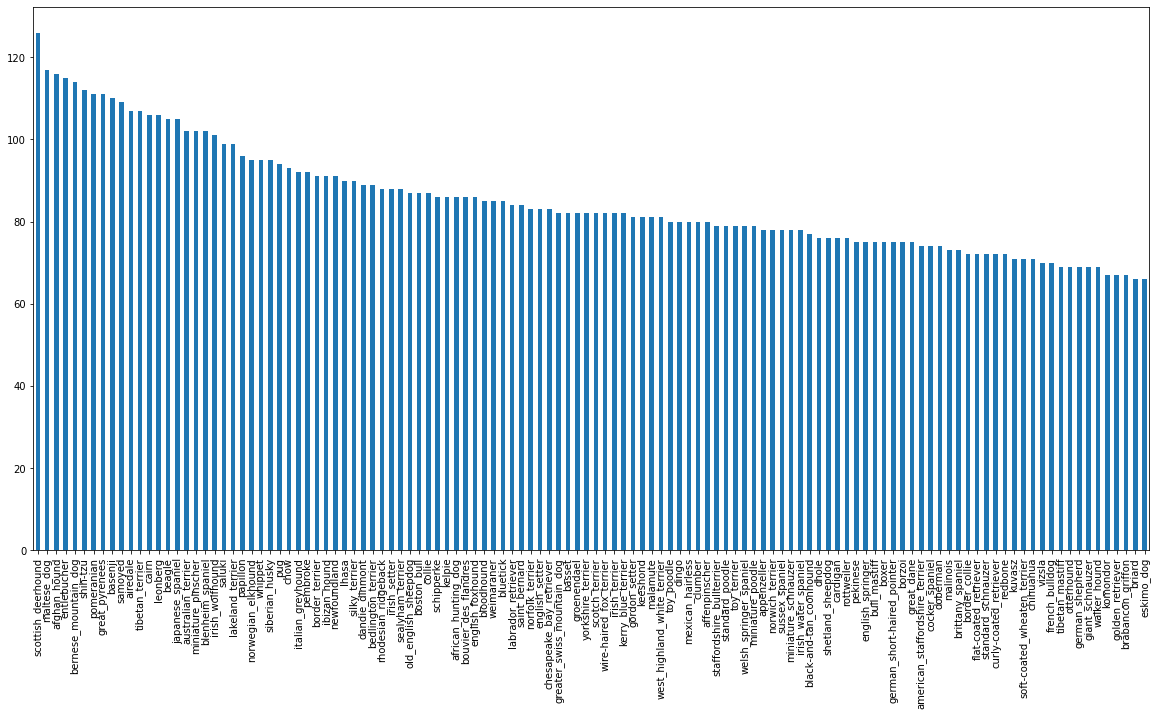

In [4]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [5]:
labels_csv["breed"].value_counts().median()

82.0

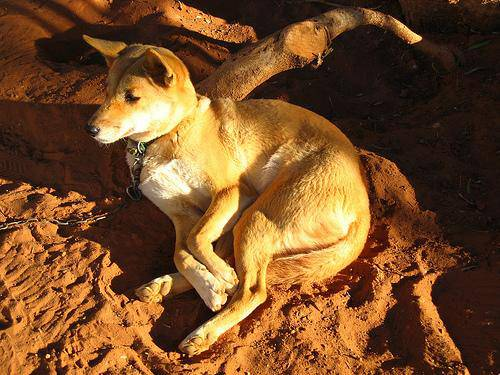

In [6]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/MLPROJECT/DOG_VISON/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and thier labels

Let's get a list of all of our image file pathnames.

In [7]:
# Create pathnames from image ID's
filenames = ["drive/MyDrive/MLPROJECT/DOG_VISON/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 5
filenames[:5]

['drive/MyDrive/MLPROJECT/DOG_VISON/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/MLPROJECT/DOG_VISON/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/MLPROJECT/DOG_VISON/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/MLPROJECT/DOG_VISON/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/MLPROJECT/DOG_VISON/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [8]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/MLPROJECT/DOG_VISON/train/")) == len(filenames):
  print("Proceed")
else:
  print("Numbers not matched")

Proceed


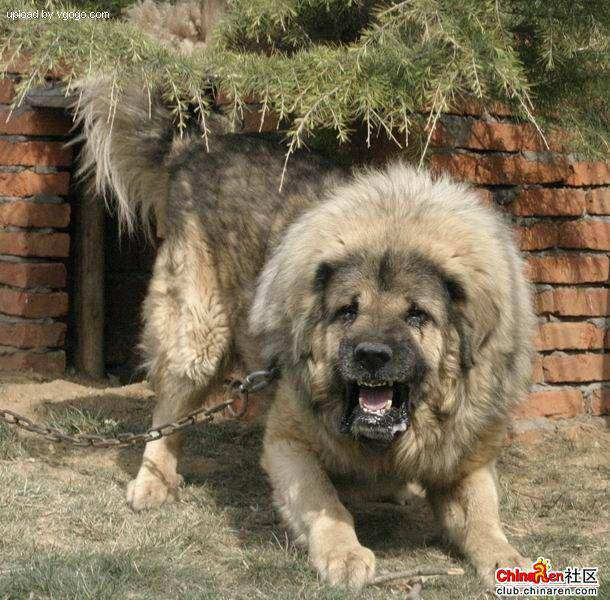

In [9]:
Image(filenames[9000])

In [10]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepath in a list, let's prepare our labels.

In [11]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
len(labels)

10222

In [13]:
## See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("matched")
else:
  print("Not matched")

matched


In [14]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [15]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [17]:
len(boolean_labels)

10222

In [18]:
# Example: Turning boolean array into integers
print(labels[0]) # origin label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [19]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from kaggle does not come with validation set, we're going to create our own.

In [20]:
# setup X & y variables
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [21]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000}

In [22]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [23]:
# Let's see the data
X_train[:5], y_train[:2]

(['drive/MyDrive/MLPROJECT/DOG_VISON/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/MLPROJECT/DOG_VISON/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/MLPROJECT/DOG_VISON/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/MLPROJECT/DOG_VISON/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/MLPROJECT/DOG_VISON/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fals

### Preprocessing Images (turning images into tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `images` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [24]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [25]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [26]:
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [28]:
# let's make the function

# define image size
IMG_SIZE = 224

# Create preprocessing function

def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turn the image into a Tensor.
  """
  #read in an image file
  image = tf.io.read_file(image_path)
  #turn the jpg image into numerical Tensor with 3 color channels (red, green, blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  #resize the image to our desired value (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


### Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time ( you can manually adjust batch size)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: (`image`,`label`)

In [29]:
# create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [32]:
# demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all our data (x & y) into batches.

In [34]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's a validation data.
  Also accepts test data as input (no labels).
  """

  # If the data is test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches.....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  #if the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches.....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches.....")
    #Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    #shuffling pathnames and labels
    data = data.shuffle(buffer_size=len(X))
    #create (image, label) tuples
    data = data.map(get_image_label)
    #turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [35]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches.....
Creating validation data batches.....


In [36]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing Data Batches

Our data is now in batches, let's visualize them.

In [44]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, lables):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25
  for i in range(25):
    # create subplots
    ax = plt.subplot(5,5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[y[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

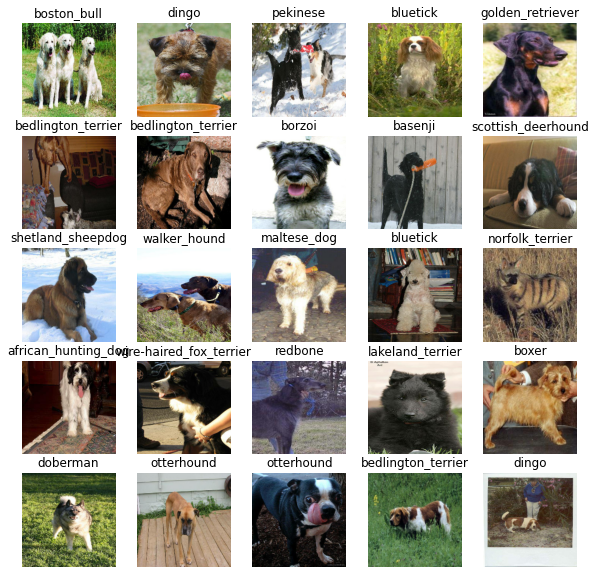

In [50]:
# let's visualize
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

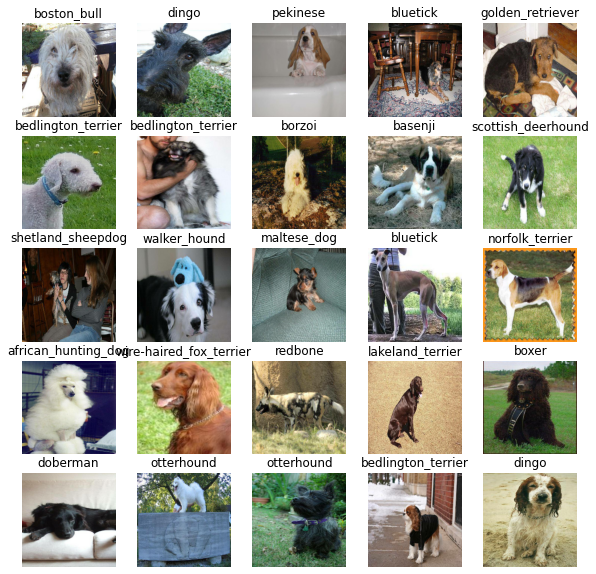

In [51]:
# now let's visualize validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:

* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use. Which is from TensorFlow Hub - https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"